------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis)__ 
------------------------------------------------------------------------------------------------------------------------

In [134]:
#this line imports the functions needed for this project
from source_code.general_functions import select_time_range
from source_code.dwd_data_explore import get_links, show_available_data, ids_datapoints, common_stations, plot_points_germany
from source_code.dwd_data_download import download_dwd_data
#from source_code.plot_functions import plot_optimal_temperature, plot_lw_RHt, plot_lw_dpd, plot_dryness # Will think how to include
from source_code.fusarium import plot_risk_fusarium, equation_fusarium, equation_fusarium_rh, plot_combined_risk_fusarium
from source_code.lm_fusarium import linear_model_temperature, linear_model_moisture
from source_code.bbch_functions import plot_harvest_date_mais, quantile_date_stage_crop


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Hypothesis

1) Recent (since 1990 ) changes in climate cause more frequent favourable disease events in key phenological stages that potentially lead to infection risk than the years before (1950-1989).

2) However, those changes occur at different intensities across Germany. Higher risks in the more martime regions (higher rainfall &  higher temperature)

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [135]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters = parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [136]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (common_stations(common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['00701', '02290', '00867', '05100', '01639', '03730', '01691', '04887', '01975', '03631', '04104', '02261', '02601', '02014', '04371', '05371', '05906', '01550', '00691', '05705', '05792', '03032', '02597', '00656']


Upon data check, I noticed that id "02290" has the moisture only for one year, even though in the name it says that it is available for all the timeframe. It will be removed from the analysis.

### Let's plot the stations to make sure that the points are representative for whole Germany:

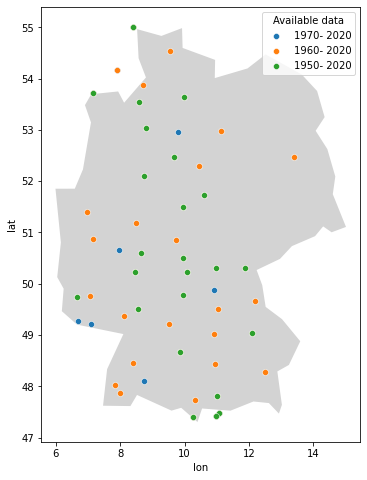

In [137]:
plot_points_germany(dwd_links)

In [138]:
try:
    common_ids.remove("02290")
except:
    print("ID was already removed")
try:
    common_ids.remove("03032") # island
except:
    print("ID was already removed")
try:
    common_ids.remove("03730") # 800m
except:
    print("ID was already removed")
try:
    common_ids.remove("01550") # 700m
except:
    print("ID was already removed")
try:
    common_ids.remove("05792") # 2900m
except:
    print("ID was already removed")


In [139]:
#to_exp = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")
#to_exp.id = to_exp.id.apply(lambda x: str(x).zfill(5))
#to_exp.to_csv("app/coordinates.csv")

#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

### Approximating BBCH for analysis




Q1 quantile of arr :  260.0
Q2 quantile of arr :  269.0
Q3 quantile of arr :  280.0
90% of corn is harvested at :  289.0
95% of corn is harvested at :  295.0
99% of corn is harvested at :  304.0


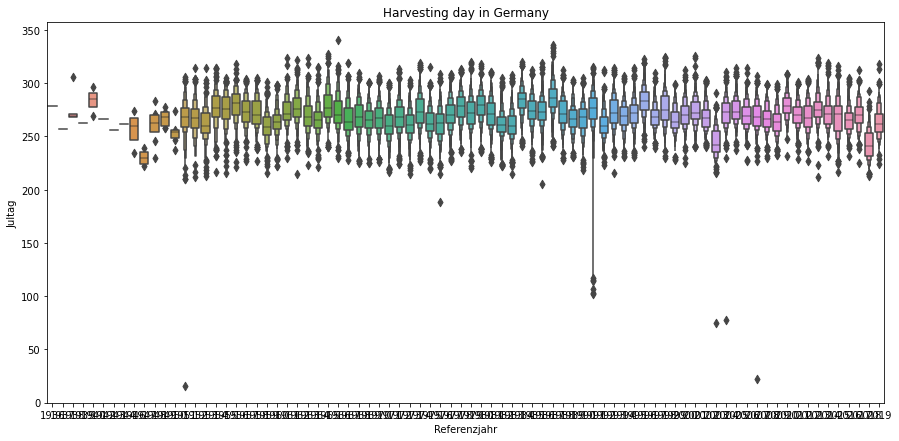

In [140]:
plot_harvest_date_mais()

In [141]:
corn_harvest_date = quantile_date_stage_crop("mais",0.90,24)
wheat_bbch75 = quantile_date_stage_crop("wheat",0.90,19)

wheat_sawing_date = quantile_date_stage_crop("wheat",0.90,10)
wheat_harvest_date = quantile_date_stage_crop("wheat",0.90,23)
print(f"""Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest {corn_harvest_date}
Wheat - bbch75 {wheat_bbch75}

General for wheat:
------------------------
 Sawing date: {wheat_sawing_date}
 Harvest: {wheat_harvest_date}
 """)

Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest 16.10
Wheat - bbch75 20.07

General for wheat:
------------------------
 Sawing date: 27.10
 Harvest: 26.08
 


## Step 2. Obtaining the data and ensuring quality
### 1. Temperature

In [142]:
df_airtemp = download_dwd_data("air_temperature","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)
#Replacing non-existent values
df_airtemp.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


(0.0, 300000.0)

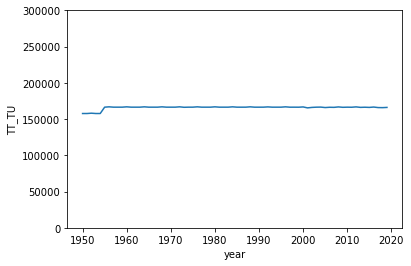

In [143]:
#Step 1. Checking data integrity:

df = df_airtemp.copy()
measures = df.groupby("year").count()
fig = plt.figure()
ax = sns.lineplot(x=measures.index,y=measures.TT_TU)
ax.set_ylim(bottom = 0, top = 300000)


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

### 2. Air humidity (RH)

In [144]:
df_moisture= download_dwd_data("moisture","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing non-existent values
df_moisture.replace(-99.9, np.nan, inplace=True)

All given ids accounted for


Text(0, 0.5, 'Number of measures')

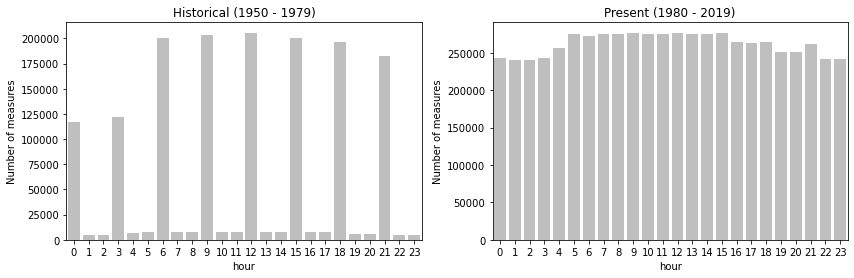

In [145]:
hist_moisture = df_moisture[df_moisture["year"]<1980].groupby("hour").count()
recent_moisture = df_moisture[df_moisture["year"]>=1980].groupby("hour").count()

fig, ax =plt.subplots(1,2,figsize=(14,4))
sns.barplot(x= hist_moisture.index, y = hist_moisture["RF_STD"], color = "0.75", ax= ax[0])
sns.barplot(x= recent_moisture.index, y = recent_moisture["RF_STD"], color = "0.75", ax= ax[1])
ax[0].set_title("Historical (1950 - 1979)")
ax[1].set_title("Present (1980 - 2019)")
ax[0].set_ylabel("Number of measures")
ax[1].set_ylabel("Number of measures")

We can observe from here that in this time period, the relative humidity was mostly measured from 3 to 3 hours, during the working time, as the measuring process was mostly manual.
From 1980, the data is measured more constantly. A solution is to limit the analysis on the hours that are measured.

In [146]:
df_moisture = df_moisture[df_moisture["hour"].isin([6, 9, 12, 15, 18, 21])]

## Step 2. Obtaining the data and ensuring quality
## Fusarium graminearum - air temperature and moisture

In [147]:
"""plot_risk_fusarium(df_airtemp, df_moisture,
temp_min=15,temp_max=25,
hist_start=1950,hist_end=1979,
#start_dd_mm="01.09", end_dd_mm="01.05",
start_dd_mm=corn_harvest_date, end_dd_mm=wheat_harvest_date, 
moving_average=7 
)"""

'plot_risk_fusarium(df_airtemp, df_moisture,\ntemp_min=15,temp_max=25,\nhist_start=1950,hist_end=1979,\n#start_dd_mm="01.09", end_dd_mm="01.05",\nstart_dd_mm=corn_harvest_date, end_dd_mm=wheat_harvest_date, \nmoving_average=7 \n)'

### Combined risk

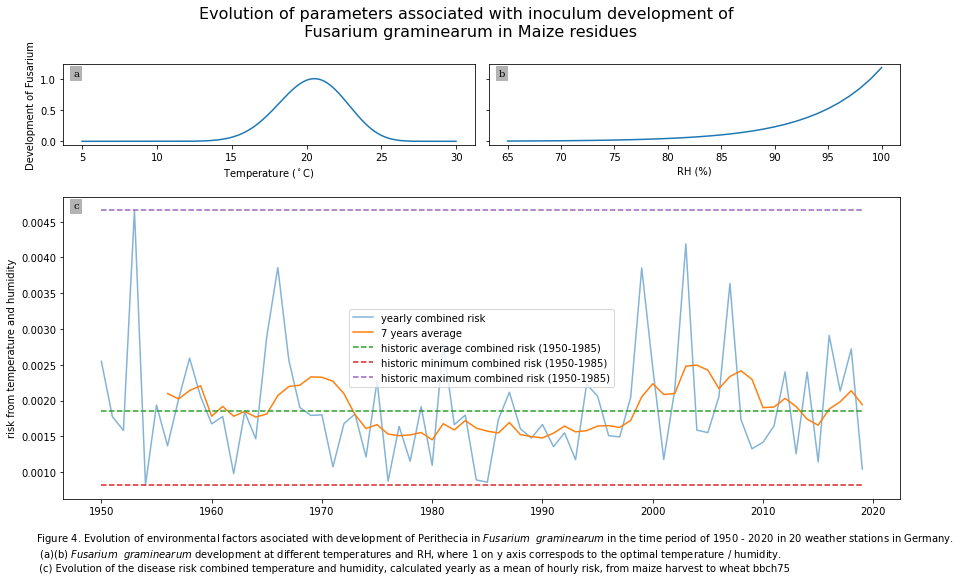

In [148]:
plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75 , transf = None)

### Now with sqrt

/Users/serbanradulescu/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/pandas/core/window/rolling.py:348: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)
/Users/serbanradulescu/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/serbanradulescu/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/serbanradulescu/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/serbanradulescu/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: 

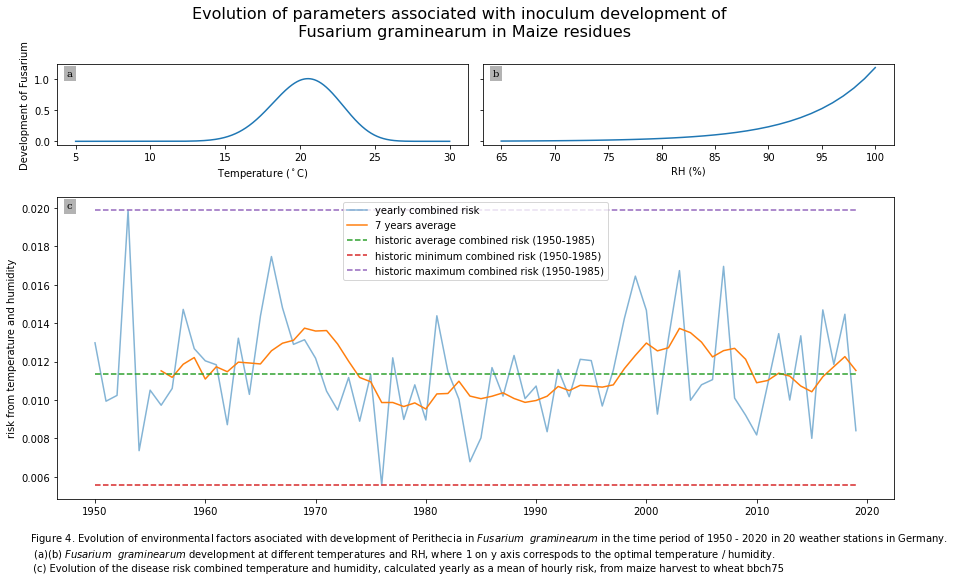

In [149]:
plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75, transf = "sqrt")

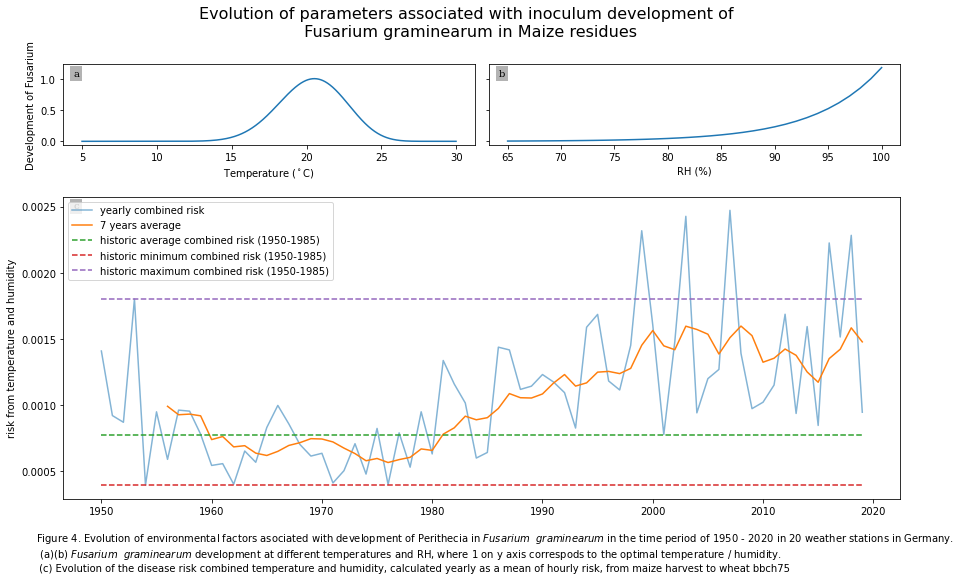

In [150]:
plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75, transf = "LTRH80")

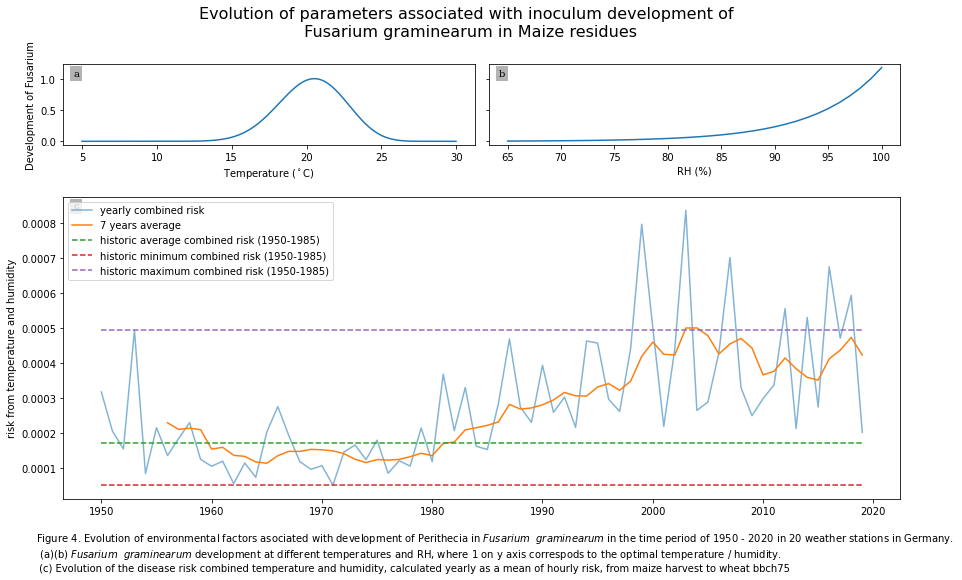

In [151]:
plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75, transf = "LTRH90")

# Making a linear regression

In [152]:
from typing import Optional
from source_code.lm_fusarium import linear_model_combined
import geopandas as gpd
from source_code.dwd_data_explore import coordinates_stations

def lm_models_germany(df_lm_summary, transf):
    """plots the points for"""
    # Preparing the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)
    # Plotting for each time range


    common_ids = [id for id in df_lm_summary["id"].values]
    
    stations_coordinates = coordinates_stations(
        common_ids,
        "downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt",
    )
    
    stations_coordinates = pd.merge(stations_coordinates,df_lm_summary[["id","category"]], how = "left", on="id")
    stations_coordinates.sort_values(by="category", inplace=True)
    sns.scatterplot(
        x="lon", y="lat", hue = "category", 
        palette = {"1A":"#ff3300",'1B':"#ff5c33","1C":"#ff5c99",'2A':"#003d99", '2B':"#0066ff" ,'2C':"#80b3ff" ,'3A':"#009900", '3B':"#80ff80","3C":"#80ff00", 'AN':"#000066", },  
        data=stations_coordinates, s = 100,
    )  
    plt.legend(title="lm results")
    plt.title(f"{transf}")
    plt.show()

def linear_models_analysis(transf: Optional[str]=None):
    
    # Call the models
    lm_fusarium_t = linear_model_temperature(df_airtemp,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium,year_minus=0)
    lm_fusarium_rh = linear_model_moisture(df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium_rh,year_minus=0)
    lm_fusarium_combined = lm_fusarium_combined = linear_model_combined(df_airtemp, df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75,func1 = equation_fusarium, func2= equation_fusarium_rh, year_minus=0, transf = transf)

    #Save them for interpretation
    if transf == None:
        prefix = "v1"
    else:
        prefix = transf
    lm_fusarium_t.to_csv("results/lm_fusarium_t.csv", float_format='%.5f')
    lm_fusarium_rh.to_csv("results/lm_fusarium_rh.csv",float_format='%.5f')
    lm_fusarium_combined.to_csv(f"results/lm_fusarium_combined_{prefix}.csv", float_format='%.5f')

    # Create the merged interpretation for ppt
    lm_fusarium_t_ppt = lm_fusarium_t[["station id","conclusion"]].rename(columns={"conclusion":"temperature"})
    lm_fusarium_rh_ppt = lm_fusarium_rh[["station id","conclusion"]].rename(columns={"conclusion":"humidity"})
    lm_fusarium_combined_ppt = lm_fusarium_combined[["station id","conclusion"]].rename(columns={"conclusion":"temperature and humidity"})
    lm_fusarium_ppt = lm_fusarium_combined_ppt.merge(lm_fusarium_rh_ppt, on="station id").merge(lm_fusarium_t_ppt, on="station id")
    lm_fusarium_ppt = lm_fusarium_ppt.replace({"significant":"+", "significant but decreasing risk":"-", "non-significant":"0"})
    lm_fusarium_ppt["category"] = lm_fusarium_ppt.apply(lambda x:  str(x["temperature and humidity"])+str(x["temperature"])+str(x["humidity"]), axis=1)
    print(lm_fusarium_ppt["category"].unique())
    dict_replace = { "+++": "1A", # all risks increased
                "++0": "1B",  # combined and temperature increased
                "++-": "1C", # combined, temperature increased, humidity did not
                "0++": "2A", # temperature and humidity increased, but combined not significant
                "0+0": "2B", # temperature risk increased, humidity constant, combined not significant
                "0+-": "2C", # temperature risk increased, humidity decreased, combined not significant
                "-+0": "3A", # decreasing but temperature increased
                "-+-": "3B", # temperature increasing, humidity and combined decreasing
                "-++": "3C", # risk decreasing, both parameters increasing 
                "000": "AN", # anomaly, sky station
    }
    lm_fusarium_ppt["category"].replace(to_replace=dict_replace,inplace=True)
    print(lm_fusarium_ppt["category"].unique())
    lm_fusarium_ppt.to_csv("results/lm_fusarium_ppt.csv")

    # Prepare for plot


    summary_series =lm_fusarium_ppt['category'].value_counts().reset_index().sort_values(by="index").rename(columns={"category":"count", "index":"category"})
    lm_category_summary = pd.DataFrame(data={"category": ["1A","1B","1C","2A","2B","2C","3A","3B","3C","AN"], 
    "details":["all risks increased", "combined and temperature increased","combined, temperature increased, humidity did not","temperature and humidity increased, but combined not significant",
    "temperature risk increased, humidity risk constant, combined not significant", "temperature risk increased, humidity decreased, combined not significant",
    "decreasing but temperature increased","temperature risk increasing, humidity risk constant and combined decreasing","+--", "anomaly" ]  })
    lm_category_summary = pd.merge(summary_series,lm_category_summary, how = "left", on="category")
    print(lm_category_summary)
    lm_category_summary.to_csv("results/category_summary.csv")
    lm_fusarium_ppt.rename(columns={"station id": "id"}, inplace=True)
    lm_models_germany(df_lm_summary=lm_fusarium_ppt, transf=prefix)




### Linear model v1.

['0++' '0+-' '+++' '++0' '-+-' '-+0' '0+0']
['2A' '2C' '1A' '1B' '3B' '3A' '2B']
  category  count                                            details
0       1A      2                                all risks increased
1       1B      3                 combined and temperature increased
2       2A      4  temperature and humidity increased, but combin...
3       2B      4  temperature risk increased, humidity risk cons...
4       2C      3  temperature risk increased, humidity decreased...
5       3A      1               decreasing but temperature increased
6       3B      2  temperature risk increasing, humidity risk con...


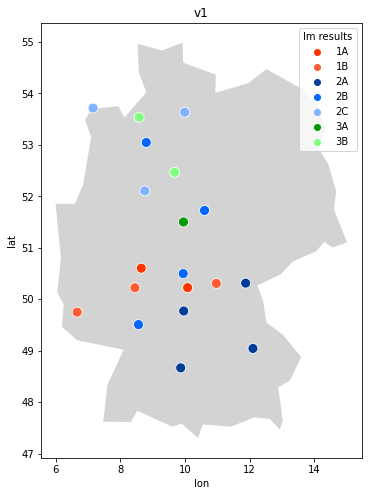

In [153]:
linear_models_analysis(transf=None)

### Linear model sqrt(v1)

['0++' '0+-' '+++' '++0' '-+-' '-+0' '0+0' '-++']
['2A' '2C' '1A' '1B' '3B' '3A' '2B' '3C']
  category  count                                            details
0       1A      2                                all risks increased
1       1B      2                 combined and temperature increased
2       2A      3  temperature and humidity increased, but combin...
3       2B      5  temperature risk increased, humidity risk cons...
4       2C      3  temperature risk increased, humidity decreased...
5       3A      1               decreasing but temperature increased
6       3B      2  temperature risk increasing, humidity risk con...
7       3C      1                                                +--


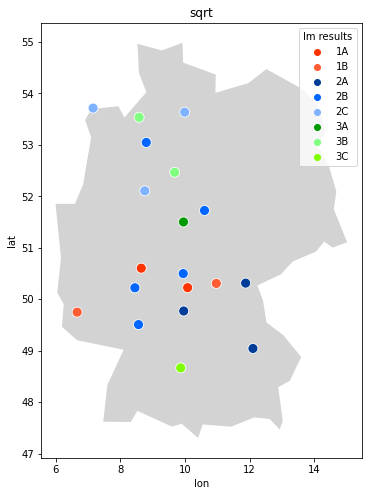

In [154]:
linear_models_analysis(transf="sqrt")

### Linear model LTRH80

['+++' '0+-' '++0' '0++' '++-' '0+0']
['1A' '2C' '1B' '2A' '1C' '2B']
  category  count                                            details
0       1A      4                                all risks increased
1       1B      4                 combined and temperature increased
2       1C      3  combined, temperature increased, humidity did not
3       2A      2  temperature and humidity increased, but combin...
4       2B      4  temperature risk increased, humidity risk cons...
5       2C      2  temperature risk increased, humidity decreased...


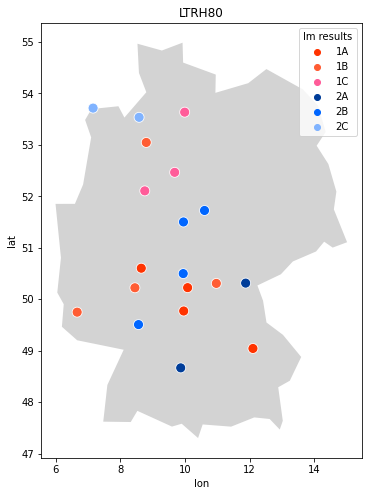

In [155]:
linear_models_analysis(transf="LTRH80")

In [156]:
### Linear model LTRH90

['+++' '++-' '++0' '0+-' '0++' '0+0']
['1A' '1C' '1B' '2C' '2A' '2B']
  category  count                                            details
0       1A      4                                all risks increased
1       1B      6                 combined and temperature increased
2       1C      4  combined, temperature increased, humidity did not
3       2A      2  temperature and humidity increased, but combin...
4       2B      2  temperature risk increased, humidity risk cons...
5       2C      1  temperature risk increased, humidity decreased...


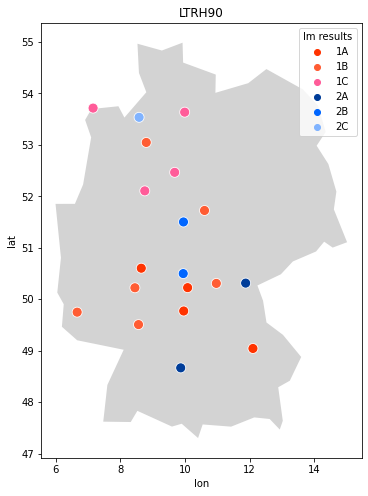

In [157]:
linear_models_analysis(transf="LTRH90")

### Preparing for .ppt

In [158]:
# Step 2.1: merge the dataframes on the needed parameters
common_cols = ["MESS_DATUM", "STATIONS_ID", "year", "month", "day", "hour"]
df_merged = df_airtemp.merge(
        df_moisture,
        how="left",
        on=["MESS_DATUM", "STATIONS_ID", "year", "month", "day", "hour"],
    )
df_merged = df_merged[common_cols + ["TT_TU", "RF_STD"]]

### Now piece-wise linear regressions

In [159]:
import piecewise_regression
import matplotlib.pyplot as plt


def piecewise_fusarium(df_param:pd.DataFrame, transf:Optional[str],start_dd_mm: str,end_dd_mm: str, to_plot: bool = False):
    df_param = select_time_range(
        df_param, start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm
    )
    piecewise_dict = {}
    for station in df_param.STATIONS_ID.unique():
        df = df_param.copy()
        start_dd_mm = corn_harvest_date
        end_dd_mm = wheat_bbch75
        df = df[df["STATIONS_ID"] == station]
        df = select_time_range(df, start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm)
        
        if transf == "airtemp":
            df["concerned_parameter"] = df.TT_TU.apply(equation_fusarium)
        elif transf == "moisture":
            df["concerned_parameter"] = df.RF_STD.apply(equation_fusarium_rh)
        else:
            df["t_risk"] = df.TT_TU.apply(equation_fusarium)
            df["rh_risk"] = df.RF_STD.apply(equation_fusarium_rh)
            if transf == "v1":
                df["concerned_parameter"] = df.apply(lambda x: (x["rh_risk"] * x["t_risk"]), axis=1)
            elif transf == "sqrt":
                df["concerned_parameter"] = df.apply(
                    lambda x: np.sqrt(x["rh_risk"] * x["t_risk"]), axis=1)
            elif transf == "LTRH80":
                df["concerned_parameter"] = df.apply(lambda x: x["t_risk"] if x["RF_STD"] > 80 else 0, axis=1)
            elif transf == "LTRH90":
                df["concerned_parameter"] = df.apply(lambda x: x["t_risk"] if x["RF_STD"] > 90 else 0, axis=1)

        df = df.groupby(["year"]).mean().reset_index()
        x = [i for i in df.year]
        y = [i for i in df.concerned_parameter]
        try:
            pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
            pw_results = pw_fit.get_results()
            piecewise_dict[station] = pw_results["estimates"]["breakpoint1"]["estimate"]
            print(station, pw_results["estimates"]["breakpoint1"]["estimate"])
        except: 
            piecewise_dict[station] = 0
            print(station, "No breaking point")
        if to_plot == True and piecewise_dict[station] != 0:
            fig = plt.figure()
            # Plot the data, fit, breakpoints and confidence intervals
            pw_fit.plot_data(color="grey", s=20)
            # Pass in standard matplotlib keywords to control any of the plots
            pw_fit.plot_fit(color="red", linewidth=2)
            pw_fit.plot_breakpoints()
            pw_fit.plot_breakpoint_confidence_intervals()
            plt.title(f"Station:{station}, model: fusarium {transf}")
            plt.xlabel("x")
            plt.ylabel("y")
            #plt.show()
            fig.savefig(f'results/plots/piecewise/{transf}/{station}.png')
            plt.close()
    piecewise_df = pd.DataFrame.from_dict(piecewise_dict, orient="index").reset_index().rename(columns={"index":"id", 0:"breakpoint"})
    return piecewise_df

piecewise_df_temp = piecewise_fusarium(df_param = df_airtemp, transf= "airtemp",start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, to_plot= True)
#piecewise_df_moisture = piecewise_fusarium(df_param = df_moisture, transf= "moisture", to_plot= False)
#pieceweise_df_LTRH90 = piecewise_fusarium(df_param = df_merged, transf= "LTRH90",start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, to_plot= True)


04104 1954.1661564831952
03631 1955.1669957582067
02597 1984.0325782854684
05705 1960.7756840106872
00867 2004.0668584628
00701 1954.9735810919558
02261 1954.4440912540017
05100 1984.5166493690492
01639 2001.711921050625
02014 1955.4480716086157
01691 1973.511322379732
05906 No breaking point
04371 1994.513666755442
05371 1960.5349061306756
00656 2009.6557313890696
04887 1952.7565502154139
01975 No breaking point
02601 1984.9276977901475
00691 1980.4953169304533


       id   breakpoint
0   04104  2009.355365
1   03631  1962.116961
3   02597  1976.580220
4   05705  1968.616365
7   02261  2007.059673
8   05100  1961.373486
9   01639  1971.080043
10  01550  1998.137249
11  02014  2009.576307
12  01691  1984.316434
15  04371  1983.664361
17  00656  1968.919810
18  04887  1961.705353
19  03032  1969.968105
20  01975  1997.068898
22  00691  1962.206077


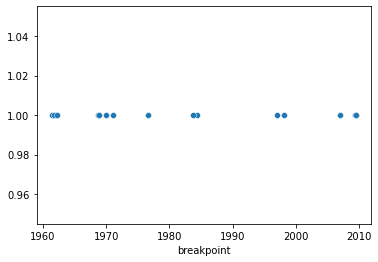

In [160]:
plot_piecewise = pieceweise_df_LTRH90[pieceweise_df_LTRH90["breakpoint"] != 0]
piecewise_ids = ['04104', '03631', '03730', '02597', '05705', '00701', '02261', '05100', '01639', '01550', '02014', '01691', '05906', '05792', '04371', '05371', '00656', '04887', '03032', '01975', '02601', '00691']
piecewise_ids_v1 = ["05705","03631","01639","05100","03032","01691", "00691","02597", "01975","04887","04371","00656","01550"]
plot_piecewise = plot_piecewise[plot_piecewise["id"].isin(piecewise_ids)]
plot_piecewise = plot_piecewise[plot_piecewise["breakpoint"]<2010]
plot_piecewise = plot_piecewise[plot_piecewise["breakpoint"]>1960]
print(plot_piecewise)

ax = sns.scatterplot(x = plot_piecewise["breakpoint"], y = 1)


In [161]:
#piecewise_ids =pieceweise_df_LTRH90[pieceweise_df_LTRH90["breakpoint"] != 0]["id"].values
#piecewise_ids = [i for i in piecewise_ids]
#print(piecewise_ids)

       id      lat      lon   breakpoint
17  05100  49.7479   6.6583  1961.373486
16  04887  48.6656   9.8648  1961.705353
12  03631  53.7123   7.1519  1962.116961
1   00691  53.0451   8.7981  1962.206077
19  05705  49.7704   9.9576  1968.616365
0   00656  51.7234  10.6021  1968.919810
11  03032  55.0110   8.4125  1969.968105
4   01639  50.6017   8.6439  1971.080043
9   02597  50.2240  10.0792  1976.580220
15  04371  52.1042   8.7521  1983.664361
5   01691  51.5002   9.9507  1984.316434
6   01975  53.6332   9.9881  1997.068898
3   01550  47.4830  11.0621  1998.137249
8   02261  50.3123  11.8760  2007.059673
14  04104  49.0425  12.1019  2009.355365
7   02014  52.4644   9.6779  2009.576307


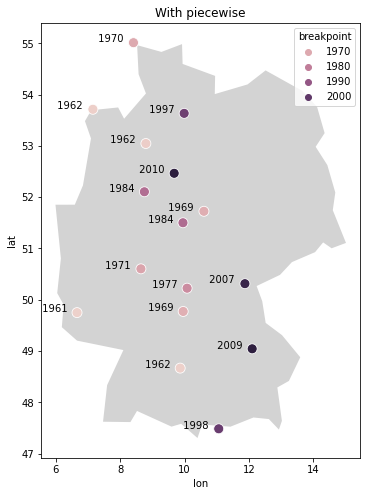

In [162]:
# Let's plot the 13 I would say are clearly better explained by a piecewise regression:
def plot_germany_piecewise_models(plot_piecewise:pd.DataFrame, piecewise_ids:list):
    # Preparing the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)

    # Plotting for each time range
    common_ids = piecewise_ids

    stations_coordinates = coordinates_stations(
        common_ids,
        "downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt",
    )

    # Merging it with the two
    stations_coordinates = pd.merge(stations_coordinates,plot_piecewise[["id","breakpoint"]], how = "left", on="id")
    stations_coordinates.dropna(inplace = True)


    

    
   
    stations_coordinates.sort_values(by="breakpoint", inplace=True)
    print(stations_coordinates)
    sns.scatterplot(
        x="lon", y="lat", hue = "breakpoint", 
        data=stations_coordinates, s = 100,
    )  
    for x,y,z in zip(stations_coordinates["lon"],stations_coordinates["lat"],[round(i) for i in stations_coordinates["breakpoint"]]):
        ax.text(x-0.75,y+0.01,f'{z: .0f}',horizontalalignment='center',color='black',weight='light')
    plt.title(f"With piecewise")
    plt.show()
    """
    """

plot_germany_piecewise_models(plot_piecewise, piecewise_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


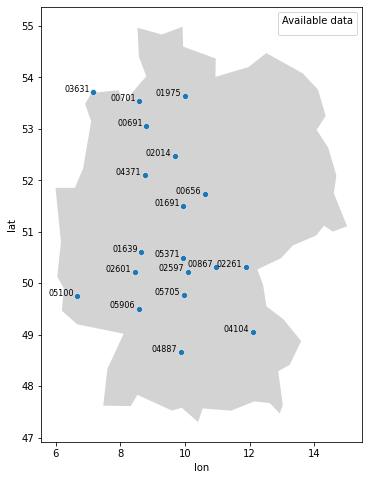

In [163]:
import matplotlib.pyplot as plt
def plot_selected_points_germany(common_ids):
    """plots the points for"""
    # Preparing the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)
    # Plotting for each time range

    stations_coordinates = coordinates_stations(
            common_ids,
            "downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt",
        )

    sns.scatterplot(
            x="lon", y="lat", data=stations_coordinates, 
        )  # ,title=f"Weather stations that measure the parameters required for applying \n the disease models in the time period of {start_year} - present",  ax=ax)
    #print(stations_coordinates.columns)
    plt.legend(title="Available data")
    for x,y,z in zip(stations_coordinates["lon"],stations_coordinates["lat"],[i for i in stations_coordinates["id"]]):
        ax.text(x-0.5,y+0.01,f'{z}',horizontalalignment='center',color='black',weight='light', fontsize = 8)
    plt.show()
plot_selected_points_germany(common_ids)

### Old code, might include this or not

In [164]:
"""
plot_optimal_temperature(df_airtemp, 
    temp_min=15,temp_max=25,
    hist_start=1950,hist_end=1985,
    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
    moving_average=7)"""

'\nplot_optimal_temperature(df_airtemp, \n    temp_min=15,temp_max=25,\n    hist_start=1950,hist_end=1985,\n    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, \n    moving_average=7)'

In [165]:
### Now let's try to plot it only for the hours where we have the measurement value correct
"""plot_lw_RHt(df_moisture,
            thresholds=[87,90,93],
            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
            hist_start=1950,hist_end=1985, 
            hours=[3,6,9,12,15,18,21],
            moving_average=7,
            )"""

'plot_lw_RHt(df_moisture,\n            thresholds=[87,90,93],\n            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, \n            hist_start=1950,hist_end=1985, \n            hours=[3,6,9,12,15,18,21],\n            moving_average=7,\n            )'

### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

In [166]:
"""df_dryness = df_moisture.copy()
plot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)"""

'df_dryness = df_moisture.copy()\nplot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)'

# Leaf wetness model 2

"The difference between T and dew point temperature (Td) is the dew point depression (DPD) which has also been suggested as a LWD estimator by Huber and Gillespie (1992) and Gillespie et al. (1993), based on the same observations done by Monteith (1957) in relation to RH. Duration of wetness is estimated as the length of time that DPD remains between two specific limits. The wetness criteria for this study were DPD ≤ 1.8 °C for wetness onset and DPD ≥ 2.2 °C for wetness dry-off (Rao et al., 1998)."

In [167]:
"""df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing unknown values with np.nan so they will not be counted in the statistic
df_dew_point.replace(-999.0, np.nan, inplace=True)"""

'df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)\n\n#Replacing unknown values with np.nan so they will not be counted in the statistic\ndf_dew_point.replace(-999.0, np.nan, inplace=True)'

In [168]:
#Checking data integrity and quality
"""df_dpd = df_dew_point.copy()
measures = df_dpd.groupby("year").count()
sns.lineplot(x=measures.index,y=measures.TD)
plot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)"""

'df_dpd = df_dew_point.copy()\nmeasures = df_dpd.groupby("year").count()\nsns.lineplot(x=measures.index,y=measures.TD)\nplot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)'